# Random Forest Model for AAPL Stock Direction Prediction



## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load and Merge Data

In [2]:
# Load financial and sentiment data
aapl_finance_df = pd.read_csv('../AAPL Data/AAPL_finance_data.csv')
aapl_sentiment_df = pd.read_csv('../AAPL Data/AAPL_avg_sentiment_data.csv')

# Merge datasets on Date
merged_aapl_df = pd.merge(aapl_finance_df, aapl_sentiment_df, on='Date', how='inner')

print(f"Dataset shape: {merged_aapl_df.shape}")
merged_aapl_df.head()

Dataset shape: (252, 16)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name_x,price_change,target,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound,Stock Name_y,sentiment_label
0,2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,AAPL,NaN,NaN,0.051286,0.851143,0.097571,0.098900,AAPL,Positive
1,2021-10-01,141.899994,142.919998,139.110001,142.649994,141.620163,94639600,AAPL,1.149994,1.0,0.024455,0.872455,0.103182,0.248255,AAPL,Positive
2,2021-10-04,141.759995,142.210007,138.270004,139.139999,138.135513,98322000,AAPL,-3.509995,-1.0,0.030900,0.910000,0.059300,0.122830,AAPL,Positive
3,2021-10-05,139.490005,142.240005,139.360001,141.110001,140.091278,80861100,AAPL,1.970001,1.0,0.042200,0.890000,0.067800,0.331000,AAPL,Positive
4,2021-10-06,139.470001,142.149994,138.369995,142.000000,140.974869,83221100,AAPL,0.889999,1.0,0.012200,0.910800,0.077000,0.243520,AAPL,Positive


## 3. Feature Engineering to Prevent Data Leakage



In [3]:
# Create lagged features (shift by 1 day to use previous day's data)
merged_aapl_df['Prev_Close'] = merged_aapl_df['Close'].shift(1)
merged_aapl_df['Prev_Volume'] = merged_aapl_df['Volume'].shift(1)
merged_aapl_df['Prev_High'] = merged_aapl_df['High'].shift(1)
merged_aapl_df['Prev_Low'] = merged_aapl_df['Low'].shift(1)

# Use today's sentiment to predict tomorrow (sentiment from tweets throughout the day)
# These don't need to be shifted since they reflect market sentiment for the next day

# Define features using ONLY previous day's prices
features = [
    'Prev_Close', 'Prev_High', 'Prev_Low', 'Prev_Volume',
    'sentiment_negative', 'sentiment_neutral', 'sentiment_positive', 'sentiment_compound'
]

# Remove rows with NaN (first row will have NaN due to shift)
merged_aapl_df = merged_aapl_df.dropna()

# Extract features and target
X = merged_aapl_df[features]
y = merged_aapl_df['target'].astype(float)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Remove any invalid entries
valid_idx = (~np.isnan(y)) & (np.isin(y, [-1, 0, 1]))
X = X[valid_idx]
y = y[valid_idx]

print(f"Valid samples: {len(y)}")
print(f"Class distribution: {np.bincount(y.astype(int) + 1)}")
print(f"\nFeatures used: {features}")

Valid samples: 251
Class distribution: [124   1 126]

Features used: ['Prev_Close', 'Prev_High', 'Prev_Low', 'Prev_Volume', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive', 'sentiment_compound']


## 4. Feature Scaling

In [4]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 5. Train-Test Split (Chronological)

**Important:** We use chronological splitting for time series data to prevent data leakage and simulate real-world prediction scenarios.

In [5]:
# 80-20 chronological split
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 200
Testing samples: 51


## 6. Train Random Forest Model

In [6]:
# Initialize Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Maximum depth of trees
    min_samples_split=5,     # Minimum samples to split a node
    min_samples_leaf=2,      # Minimum samples per leaf
    random_state=42,         # For reproducibility
    n_jobs=-1                # Use all CPU cores
)

# Train the model
rf_model.fit(X_train, y_train)
print("Model training complete!")

Model training complete!


## 7. Model Evaluation

In [7]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Check which classes are present in the test set
unique_classes = np.unique(np.concatenate([y_test, y_pred]))
print(f"\nClasses present in test set: {unique_classes}")

# Detailed classification report
print("\nClassification Report:")
class_names = {-1: 'Decrease (-1)', 0: 'No Change (0)', 1: 'Increase (1)'}
target_names = [class_names[int(c)] for c in unique_classes]
print(classification_report(y_test, y_pred, labels=unique_classes, target_names=target_names))


Test Accuracy: 0.5098

Classes present in test set: [-1.  1.]

Classification Report:
               precision    recall  f1-score   support

Decrease (-1)       0.57      0.59      0.58        29
 Increase (1)       0.43      0.41      0.42        22

     accuracy                           0.51        51
    macro avg       0.50      0.50      0.50        51
 weighted avg       0.51      0.51      0.51        51



## 8. Confusion Matrix Visualization

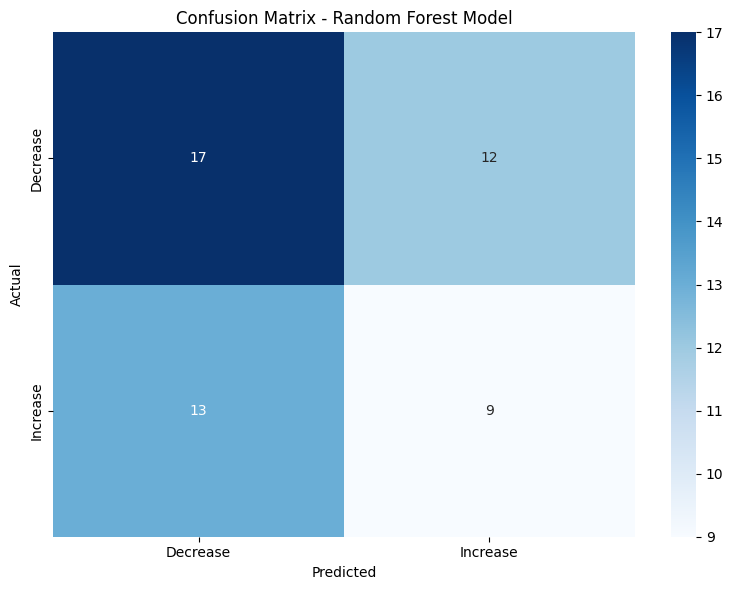

In [8]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)

# Create labels for the classes present
class_label_names = {-1: 'Decrease', 0: 'No Change', 1: 'Increase'}
labels_for_plot = [class_label_names[int(c)] for c in unique_classes]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_for_plot,
            yticklabels=labels_for_plot)
plt.title('Confusion Matrix - Random Forest Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()